In [217]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


matfile = loadmat('face.mat')
data = matfile['X']

2576

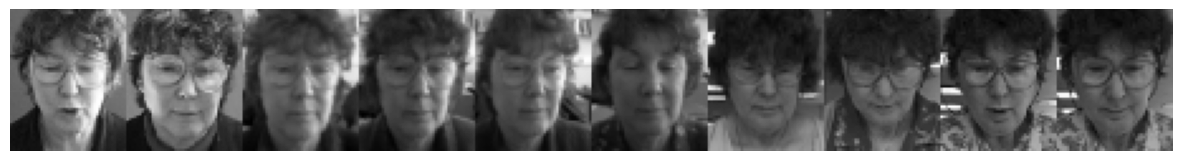

In [114]:
from PIL import Image

def create_image(array, figsize=2, savename=''):
    """Shows the image, with a fixed size of 46x56 pixels"""
    width = 46
    height = 56
    assert len(array) == width * height, "Incorrect array size"
    img_array = np.zeros([height, width], dtype=np.uint8)
    for pw in range(width):
        for ph in range(height):
            img_array[ph, pw] = array[pw * height + ph]
    #img_array = np.reshape(array, (width, height)).T
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    ax.set_axis_off()
    ax.imshow(img_array, cmap='gray')
    if savename:
        plt.imsave(f'images/{savename}', img_array, cmap='gray')


def create_image_table(array, img_per_row, figsize=15, savename=''):
    """Create table of images based on data that has multiple images, one in each row"""
    d, N = array.shape
    assert N % img_per_row == 0
    width = 46
    height = 56
    img_per_column = N // img_per_row
    img_array = np.zeros((img_per_column * height, img_per_row * width), dtype=np.uint8)
    for col in range(img_per_column):
        for row in range(img_per_row):
            # add first row of pixels from first image to img_array, then first row of second pic etc.
            image_idx = col * img_per_row + row
            for pw in range(width):
                for ph in range(height):
                    img_array[col * height + ph, row * width + pw] = array[pw * height + ph, image_idx]
    
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    ax.set_axis_off()
    ax.imshow(img_array, cmap='gray')
    if savename:
        plt.imsave(f'images/{savename}', img_array, cmap='gray')

def save_image(fig, savename: str):
    save_location = f'images/{savename}'
    fig.savefig(save_location)

create_image_table(data[:, :10], 10, figsize=15)

In [4]:
# Split data into training and testing set. There are 10 images of each face, 520 in total.
# pick first 8 as training set and rest 2 as test set for all faces
d, N = data.shape
train_idx = []
test_idx = []
for i in range(N//10):
    s = i * 10
    train_idx.extend(list(range(s, s+8)))
    test_idx.extend(list(range(s+8, s+10)))


train_data = np.take(data, train_idx, axis=1)
test_data = np.take(data, test_idx, axis=1)

In [219]:
train_data.shape

(2576, 416)

## Standard PCA

Solve the eigenvalue problem for the covariance matrix $S$, where:
$$
S = \frac{1}{N}\sum_{n=1}^{N}(x_n - \bar{x})(x_n - \bar{x})^T
$$
$\bar{x}$ is the mean vector

In [142]:
from matplotlib.pyplot import title
from numpy import signedinteger
from sklearn.preprocessing import normalize, scale

# Standard PCA 
def do_pca(data_array):
    """Perform basic pca. Expects inputs to be columns of images"""
    d, N = data_array.shape
    data_mean = np.mean(data_array, axis=1)
    expanded_mean = np.array([data_mean for _ in range(N)]).T  # make (d, N) vector for subraction
    A = data_array - expanded_mean
    S = (1 / N) * (A @ A.T)
    assert S.shape == (d, d)
    # get the eigendecomposition
    (eigvals, eigvecs) = np.linalg.eig(S)
    signed_eigvecs = force_negative(eigvecs)
    return (eigvals, signed_eigvecs)

def do_lowdim_pca(data_array):
    """Calculate A^T A instead of AA^T, can be used when N < d"""
    d, N = data_array.shape
    data_mean = np.mean(data_array, axis=1)
    expanded_mean = np.array([data_mean for _ in range(N)]).T
    A = data_array - expanded_mean
    S = (1 / N) * (A.T @ A)
    assert S.shape == (N, N)
    # eigendecomposition
    (eigvals, eigvecs) = np.linalg.eig(S)
    # get the eigvectors of the true covariance matrix by multiplying them with A
    true_eigvecs = A @ eigvecs
    scaled_eigvecs = normalize(true_eigvecs, axis=0)
    signed_eigvecs = force_negative(scaled_eigvecs)
    return eigvals, signed_eigvecs

def force_negative(eigenvectors):
    """Make sure all vectors have negative sign for consistency, changes vector inplace"""
    for i in range(eigenvectors.shape[1]):
        if eigenvectors[0, i] > 0:
            eigenvectors[:, i] *= -1
    return eigenvectors

def upscale(array):
    """upscale to 0-255"""
    # make into 2d array if just one image is given
    if len(array.shape) != 2:
        array = np.expand_dims(array, axis=1)
    tmp = MinMaxScaler((0, 255)).fit_transform(array)
    return tmp

def reconstruct(sample_face, bases_to_save, eigvecs):
    """Project a sample onto the pca space, and reconstruct it"""
    mean_face = np.mean(train_data, axis=1)
    eig = np.real(eigvecs[:, :bases_to_save])
    # project onto pca space
    mean_reduced = sample_face - mean_face
    projection = mean_reduced.T @ eig
    # projection back to face-space
    reconstruction = mean_face + projection[0] * eig[:, 0]
    for i in range(1, len(projection)):
        reconstruction += projection[i] * eig[:, i]
    return reconstruction

def plot_eigvals(eigvals, up_to=-1, savename=''):
    fig, ax = plt.subplots(figsize=(8,5))
    plt.rc('font', size=15)
    ax.plot(eigvals[:up_to])
    ax.set_xlabel('index of eigenvalue')
    ax.set_ylabel('size of eigenvalue')
    if savename:
        fig.savefig(f'images/{savename}')

### Answer questions and create needed figures and save them

* runtime differences between full pca and lowdim pca

In [120]:
%%time
eigvals_org, eigvecs_org = do_pca(train_data)

CPU times: user 1min 5s, sys: 31.7 s, total: 1min 37s
Wall time: 36.3 s


In [189]:
%%time
eigvals_low, eigvecs_low = do_lowdim_pca(train_data)

CPU times: user 3.22 s, sys: 846 ms, total: 4.06 s
Wall time: 3.18 s


In [220]:
# looking at the CPU total time
time_full_pca = 60 + 37
time_lowdim_pca = 4.06
print(f'the lowdim pca takes {(time_lowdim_pca / time_full_pca) * 100 :.2f}% of the time the full pca does')
print("measured based on CPU time")

the lowdim pca takes 4.19% of the time the full pca does
measured based on CPU time


* plot the first 100 eigenvalues for both methods, and estimate how many eigenvalues are needed to capture 95% of the data energy

Full pca:
taking 120 eigenvalues retains 95% of data energy
Lowdim pca:
taking 43 eigenvalues retains 95% of data energy


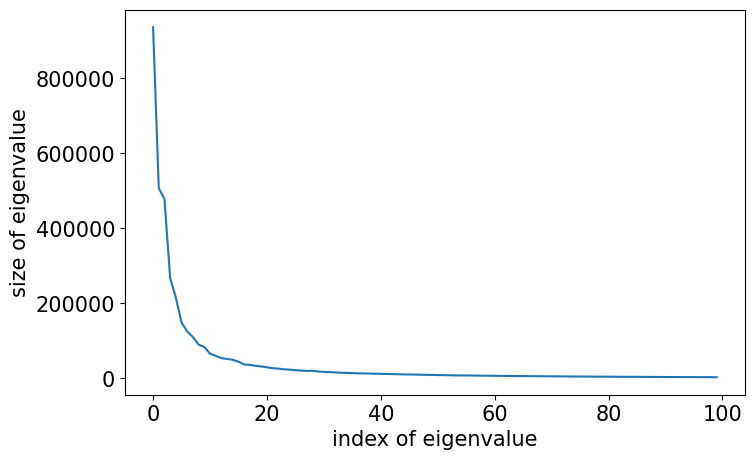

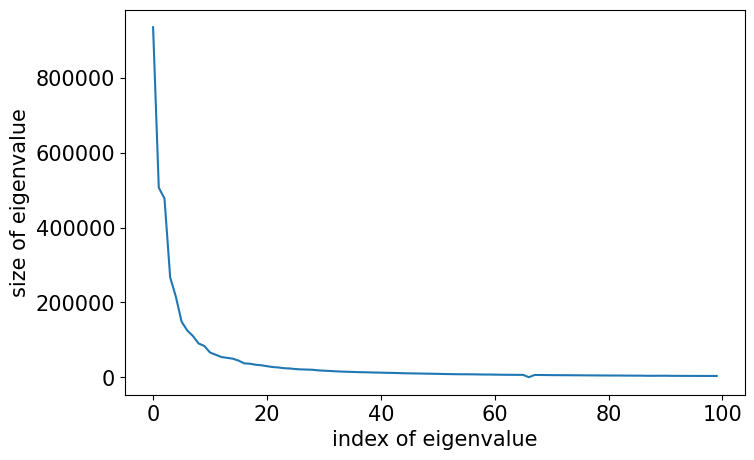

In [188]:
eigvals_org = np.real(eigvals_org)
eigvecs_org = np.real(eigvecs_org)

def find_data_energy(eigvals):
    # first find approximate point where eigvals become zero
    zero_index = 0
    for i, val in enumerate(eigvals):
        if np.abs(val) < 0.0001:
            zero_index = i
            break
    
    total_energy = np.sum(eigvals[:zero_index])
    target_energy = total_energy * 0.95
    for i in range(zero_index + 1):
        energy = np.sum(eigvals[:i])
        diff = target_energy - energy
        if diff <= 100:
            print(f'taking {i+1} eigenvalues retains 95% of data energy')
            break

print("Full pca:")
find_data_energy(eigvals_org)
print("Lowdim pca:")
find_data_energy(eigvals_low)

plot_eigvals(eigvals_org, up_to=100, savename='eigval_plot_full')
plot_eigvals(eigvals_low, up_to=100, savename='eigval_plot_low')

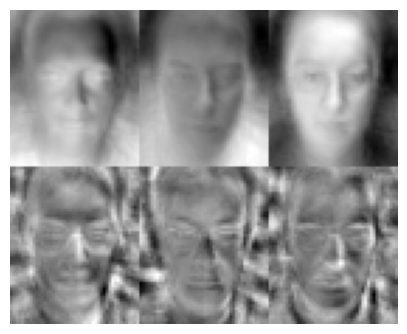

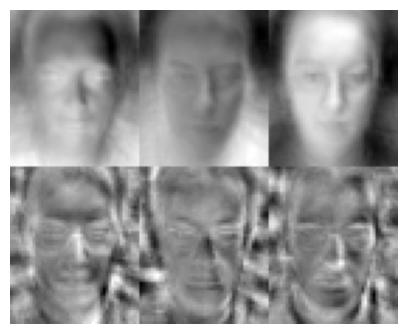

In [199]:
# Show first 3 eigenfaces, and 3 starting from index 50 of both lowdim
# and full pca
eigfaces_org = np.concatenate([eigvecs_org[:, :3], eigvecs_org[:, 50:53]], axis=1)
create_image_table(upscale(eigfaces_org), 3, figsize=5, savename='eigfaces_full.png')

eigfaces_low = np.concatenate([eigvecs_low[:, :3], eigvecs_low[:, 50:53]], axis=1)
create_image_table(upscale(eigfaces_low), 3, figsize=5, savename='eigfaces_low.png')


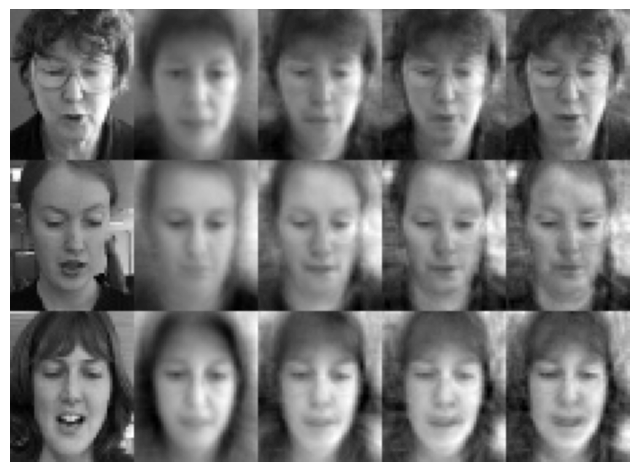

In [216]:
# show reconstruction for 3 test faces with 10, 50 and 100 eigencomponents
def create_reconstruction_sequence(sample):
    # create an array of images 
    resolutions = [10, 50, 100, 150]
    images = [sample]
    for r in resolutions:
        reconstruction = reconstruct(sample, r, eigvecs_org)
        images.append(reconstruction)
    
    return np.stack(images, axis=1)

sample1 = train_data[:, 0]
sample2 = test_data[:, 2]
sample3 = test_data[:, 5]
all_samples = [sample1, sample2, sample3]
recs = [create_reconstruction_sequence(s) for s in all_samples]
full_sequence = np.concatenate(recs, axis=1)
create_image_table(upscale(full_sequence), 5, figsize=8, savename='reconstructions.png')
